# Sudoku Detection and Solver

Through this project, we are able to Detect and Predict digits from an Unsolved Sudoku Image using Deep Learning and solve the Sudoku using Backtracking Algorithm.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
from tensorflow.keras.models import load_model
from tabulate import tabulate

## Image Processing and Sudoku Detection

In [2]:
# Preprocessing the image

def preprocess(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    
    return threshold_img

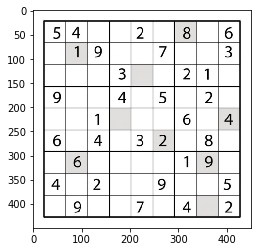

In [4]:
#Input and Resize the Image

sudoku = cv2.imread('sudoku11.jpg')
sudoku = cv2.resize(sudoku, (450, 450))
plt.imshow(sudoku)

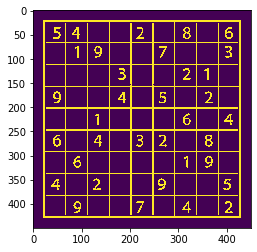

In [5]:
# Apply the Preprocessing Effects

thres = preprocess(sudoku)
plt.imshow(thres)

### Detecting Contours from the Image

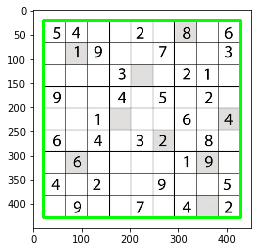

In [6]:
contour_1 = sudoku.copy()
contour_2 = sudoku.copy()

cont, hierarchy = cv2.findContours(thres,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, cont,-1,(0,255,0),3)

plt.imshow(contour_1)

### Functions to Crop and Align the Sudoku from the Image

In [8]:
def main_outline(contour_img):
    biggest = np.array([])
    max_area = 0
    
    for i in contour_img:
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
        
            if area > max_area and len(approx)==4:
                biggest = approx
                max_area = area
    
    return biggest ,max_area

In [9]:
def reframe(points):
    
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    
    return points_new

In [10]:
black_img = np.zeros((450,450,3), np.uint8)

biggest, maxArea = main_outline(cont)

if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imagewrap = cv2.warpPerspective(sudoku,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)

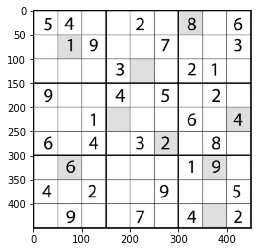

In [11]:
plt.imshow(imagewrap, cmap='gray')

In [13]:
# Apply Binary Thresholding on the Image

(thresh, bw_img) = cv2.threshold(imagewrap, 150, 255, cv2.THRESH_BINARY)

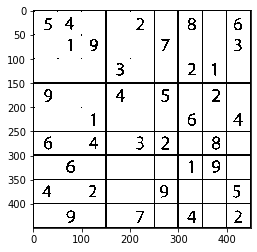

In [14]:
plt.imshow(bw_img, cmap='gray')

### Functions to Split the 9x9 Sudoku Matrix into 81 Smaller Cells and Crop Them

In [18]:
def splitcells(img):
    rows = np.vsplit(img,9)
    cells = []
    
    for r in rows:
        cols = np.hsplit(r,9)
        for cell in cols:
            cells.append(cell)
    
    return cells

In [17]:
def CropCell(cells):
    
    cropped_cells = []
    
    for image in cells:
        img = np.array(image)
        img = img[6:46, 6:46]
        img = Image.fromarray(img)
        cropped_cells.append(img)
        
    return cropped_cells

In [19]:
sudoku_cells = splitcells(bw_img)

In [20]:
sudoku_cells_croped = CropCell(sudoku_cells)

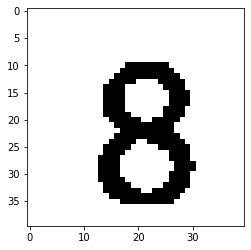

In [24]:
plt.imshow(sudoku_cells_croped[6], cmap = 'gray')

## Sudoku Cells Prediction

### Loading the CNN Model

In [25]:
model = load_model("Model.h5")
model.load_weights("Model_weights.h5")

### Predicting the Sudoku Cells and Displaying the Predictions

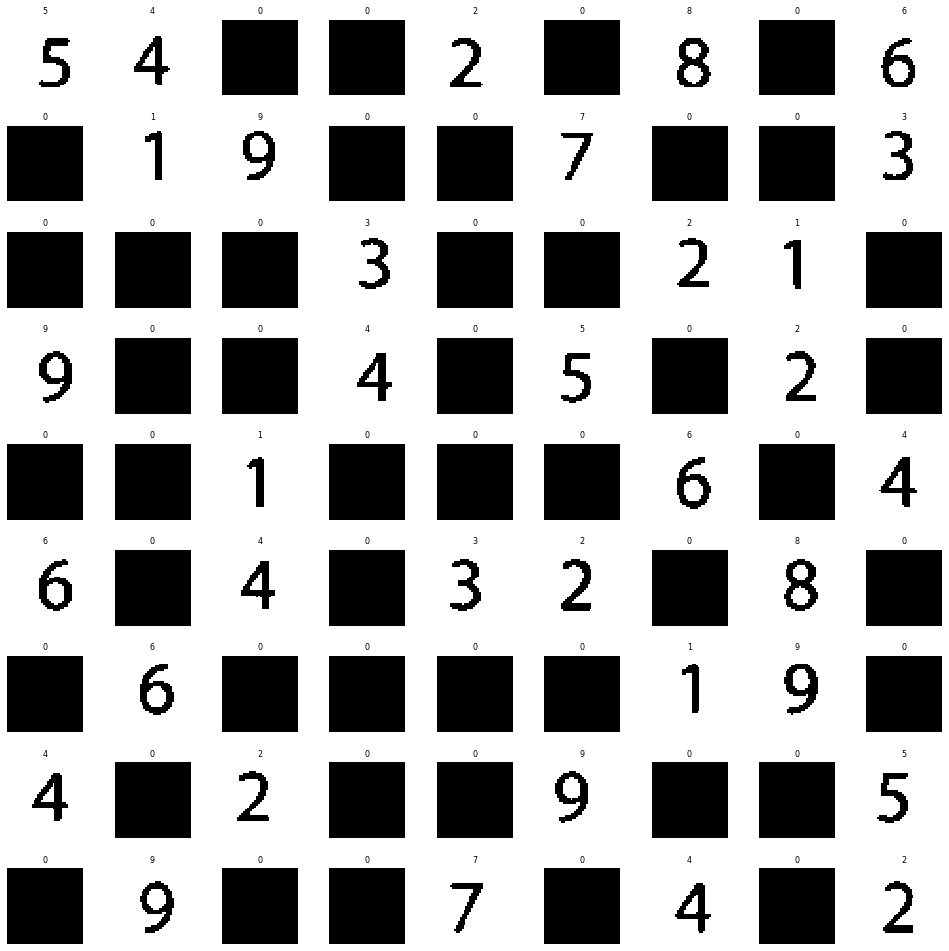

In [31]:
row = 9
col = 9

fig, axes = plt.subplots(row, col, figsize = (17,17))

axes = axes.ravel()

for i in np.arange(0, row * col):  
    
    axes[i].imshow(sudoku_cells_croped[i], cmap='gray')
    
    img = np.array(sudoku_cells_croped[i])
    img = img / 255.0
    
    pred = model.predict(img.reshape(1, 40, 40, 1))
        
    if np.max(pred) > 0.95:
        title = np.argmax(pred)
    else:
        title = 0

    axes[i].set_title(title, fontsize = 8)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

### Storing the Predictions in a Grid 

In [32]:
grid = [[0 for x in range(9)]for y in range(9)]

In [34]:
itr = 0

for i in range(9):
    for j in range(9):
        
        img = np.array(sudoku_cells_croped[itr])
        img = img / 255.0
        
        pred = model.predict(img.reshape(1, 40, 40, 1))
        
        if np.max(pred) > 0.95:
            grid[i][j] = np.argmax(pred)
        else:
            grid[i][j] = 0
            
        itr += 1

In [35]:
grid

[[5, 4, 0, 0, 2, 0, 8, 0, 6],
 [0, 1, 9, 0, 0, 7, 0, 0, 3],
 [0, 0, 0, 3, 0, 0, 2, 1, 0],
 [9, 0, 0, 4, 0, 5, 0, 2, 0],
 [0, 0, 1, 0, 0, 0, 6, 0, 4],
 [6, 0, 4, 0, 3, 2, 0, 8, 0],
 [0, 6, 0, 0, 0, 0, 1, 9, 0],
 [4, 0, 2, 0, 0, 9, 0, 0, 5],
 [0, 9, 0, 0, 7, 0, 4, 0, 2]]

## Solving Sudoku Using Backtracking Algorithm

In [36]:
n = 9

In [37]:
def is_safe(grid, row, col, num):
    
    for c in range(9):
        if grid[row][c] == num:
            return False
    
    for r in range(9):
        if grid[r][col] == num:
            return False
        
    sr = row - row % 3
    sc = col - col % 3
    
    for i in range(3):
        for j in range(3):
            
            if grid[i + sr][j + sc] == num:
                return False
            
    return True
        
def solve_sudoku(grid, row, col):
    
    if (row==n-1 and col==n):
        return True
    
    if col==n:
        row += 1
        col = 0
        
    if grid[row][col] > 0:
        return solve_sudoku(grid, row, col+1)
    
    for num in range(1, n+1, 1):
        
        if is_safe(grid, row, col, num):
            
            grid[row][col] = num
            
            if solve_sudoku(grid, row, col+1):
                return True
            
        grid[row][col] = 0
    
    return False

In [38]:
if solve_sudoku(grid, 0, 0):
    print(tabulate(grid, tablefmt = 'fancy_grid'))
else:
    print('Given Sudoku Cannot Be Solved')

╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╕
│ 5 │ 4 │ 3 │ 9 │ 2 │ 1 │ 8 │ 7 │ 6 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 2 │ 1 │ 9 │ 6 │ 8 │ 7 │ 5 │ 4 │ 3 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 8 │ 7 │ 6 │ 3 │ 5 │ 4 │ 2 │ 1 │ 9 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 9 │ 8 │ 7 │ 4 │ 6 │ 5 │ 3 │ 2 │ 1 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 3 │ 2 │ 1 │ 7 │ 9 │ 8 │ 6 │ 5 │ 4 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 6 │ 5 │ 4 │ 1 │ 3 │ 2 │ 9 │ 8 │ 7 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 7 │ 6 │ 5 │ 2 │ 4 │ 3 │ 1 │ 9 │ 8 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 4 │ 3 │ 2 │ 8 │ 1 │ 9 │ 7 │ 6 │ 5 │
├───┼───┼───┼───┼───┼───┼───┼───┼───┤
│ 1 │ 9 │ 8 │ 5 │ 7 │ 6 │ 4 │ 3 │ 2 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╛
